# **Sales Forecasting of my Shopee Store Using Time-Series Data Analysis**

This project is a sale forecasting machine learning model using time-series data from my shopee soap store. I will attempt SARIMA, Facebook Prophet and Linear Regression models to see which algorithm will be a better fit for my project. This ipynb will document the methods I will be using and I will be basing this on some papers that I have read and other people's projects. 

Although I am not that good with explaining the code that I will use I'll try my best.

In [ ]:
#import dependencies
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error




# **Data Preparation**

In [ ]:
#load the sales DataFrame

data = pd.read_csv('Shopee_Sales.csv')
data

,Date,Visitors (Visit),Buyers (Placed Orders),Units (Placed Orders),Orders (Placed Orders),Sales (Placed Orders) (PHP),Conversion Rate (Visit to Placed),Buyers (Confirmed Orders),Units(Confirmed Orders),Orders (Confirmed Orders),Sales(Confirmed Orders) (PHP),Sales per Buyer (Confirmed Orders) (PHP),Conversion Rate,Conversion Rate (Placed to Confirmed)
0,01/03/2021,16,1,4,1,240,6.25%,1,4,1,240,240.00,6.25%,100.00%
1,02/03/2021,15,0,0,0,0,0.00%,0,0,0,0,0.00,0.00%,0.00%
2,03/03/2021,18,5,45,6,"1,888",27.78%,5,45,6,"1,888",377.60,27.78%,100.00%
3,04/03/2021,10,0,0,0,0,0.00%,0,0,0,0,0.00,0.00%,0.00%
4,05/03/2021,7,0,0,0,0,0.00%,0,0,0,0,0.00,0.00%,0.00%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,24/02/2023,21,2,6,2,478,9.52%,2,6,2,478,239.00,9.52%,100.00%
726,25/02/2023,17,3,14,3,"1,133",17.65%,3,14,3,"1,133",377.67,17.65%,100.00%
727,26/02/2023,19,2,3,2,323,10.53%,2,3,2,323,161.50,10.53%,100.00%
728,27/02/2023,20,3,10,3,"2,013",15.00%,3,10,3,"2,013",671.00,15.00%,100.00%


I have to resample the data to a weekly basis because the data has way too much zeros in it and when I was testing it, it was making very horrible predictions and performances.

In [ ]:
#Select only the date and the sales data

selection = ['Date','Sales(Confirmed Orders) (PHP)']

df = data[selection]

#rename the column and convert the sales column into a float instead of a string
df = df.rename(columns={'Sales(Confirmed Orders) (PHP)': 'sales'})
df['sales'] = df['sales'].replace(',','',regex=True).astype(float)



In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y') # convert date column to datatime object

# Create Date-related Features to be used for EDA and Supervised ML: Regression

df = df.groupby(pd.Grouper(key='Date', freq='W'))['sales'].sum().reset_index()

# calculate the IQR for the data
q1 = df['sales'].quantile(0.25)
q3 = df['sales'].quantile(0.75)
iqr = q3 - q1

# filter out the rows with data outside the IQR range
#df = df.loc[(df['sales'] >= q1 - 1.5*iqr) & (df['sales'] <= q3 + 1.5*iqr)]
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month


In [ ]:
# Set the date column as the index
#df = df.set_index('Date')

# Split the data into training and testing sets
train_end = '2022-12-25'  # choose the end date of the training set
test_start = '2023-01-01'  # choose the start date of the testing set
train = df.loc[:train_end]
test = df.loc[test_start:]
test

,Date,sales,year,month
21,2021-08-01,3591.0,2021,8
22,2021-08-08,2975.0,2021,8
23,2021-08-15,1823.0,2021,8
24,2021-08-22,4791.0,2021,8
25,2021-08-29,2193.0,2021,8
...,...,...,...,...
100,2023-02-05,4097.0,2023,2
101,2023-02-12,3026.0,2023,2
102,2023-02-19,6014.0,2023,2
103,2023-02-26,3735.0,2023,2


# **Data Visualization**

Here we will do data visualization to see what happens to the data on a weekly and monthly basis.

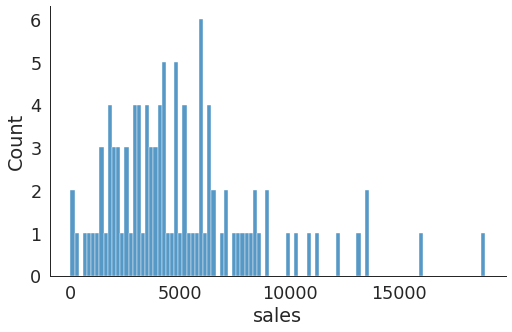

In [ ]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=df, x="sales", kind="hist", bins = 100, aspect = 1.5)

[Text(0.5, 1.0, 'Monthly sales distribution')]

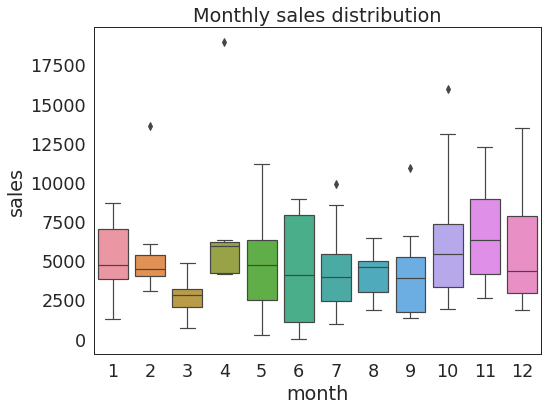

In [ ]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(x='month', y='sales', data=df).set(title='Monthly sales distribution')


This shows that the weekly sales of the soap in the store is generally the same with some outliers from time to time, especially on Sunday.

<AxesSubplot:xlabel='month', ylabel='sales'>

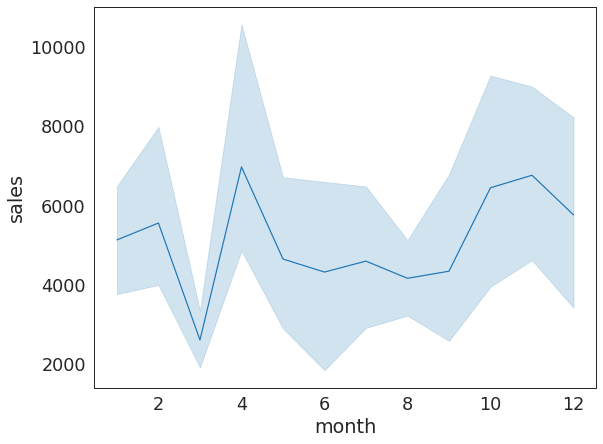

In [ ]:
fig = plt.subplots(figsize=(9,7))
sns.lineplot(x='month', y='sales', data=df)

This shows that the sale of the soaps is generally seasonal which peaks on April and October and reaches its lowest during March.

[Text(0.5, 1.0, 'Sales of Soap Over the Years')]

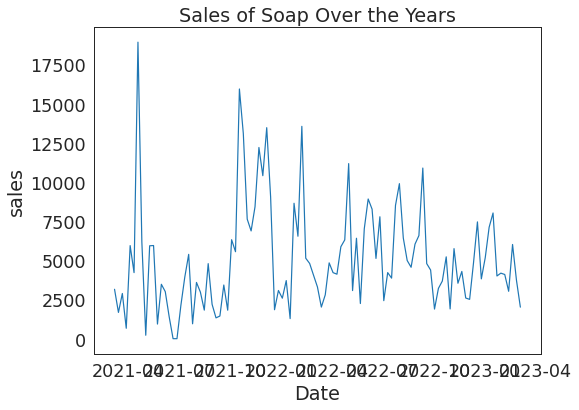

In [ ]:
fig = plt.figure(figsize=(8, 6))
sns.lineplot(x='Date', y='sales', data=df).set(title='Sales of Soap Over the Years')


The graph shows a slightly seasonal pattern of the soap sales over the years although the pattern looks a bit constant with 3 really big outlier events.

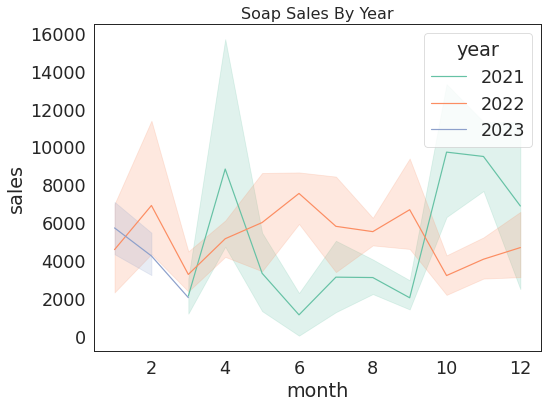

In [ ]:
fig = plt.figure(figsize=(8, 6))

plot= sns.lineplot(data=df, hue='year', x='month', y='sales',palette='Set2').set_title('Soap Sales By Year', fontsize=16)


The line comparison for each year showed that 2021 showed a bit more seasonal sales compared to 2022 which is more constant.